In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [41]:
train = pd.read_csv('Train_Data.csv')
test = pd.read_csv('Test_Data.csv')

In [42]:
train.head()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,32.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIDAGEYR   1957 non-null   float64
 2   RIAGENDR   1948 non-null   float64
 3   PAQ605     1953 non-null   float64
 4   BMXBMI     1948 non-null   float64
 5   LBXGLU     1953 non-null   float64
 6   DIQ010     1948 non-null   float64
 7   LBXGLT     1955 non-null   float64
 8   LBXIN      1957 non-null   float64
 9   age_group  1952 non-null   object 
dtypes: float64(9), object(1)
memory usage: 153.7+ KB


In [44]:
train.age_group

0       Adult
1       Adult
2       Adult
3       Adult
4       Adult
        ...  
1961    Adult
1962    Adult
1963    Adult
1964    Adult
1965    Adult
Name: age_group, Length: 1966, dtype: object

In [45]:
train.describe()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,1954.000000,1957.000000,1948.000000,1953.000000,1948.000000,1953.000000,1948.000000,1955.000000,1957.000000
mean,78683.621801,42.005621,1.510267,1.825397,27.965400,99.491039,2.015914,115.150384,11.862892
std,2924.115709,20.147601,0.500023,0.399449,7.327616,16.774665,0.187579,46.271615,9.756713
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76194.000000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.800000
50%,78717.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.030000
75%,81217.000000,58.000000,2.000000,2.000000,31.300000,104.000000,2.000000,131.000000,14.480000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


In [46]:
train.isnull().sum()

SEQN         12
RIDAGEYR      9
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

In [47]:
# SEQN is of no use and will cause unecessary errors imo, there are several missing values
train.drop(columns=["SEQN"], inplace=True)
test_ids = test['SEQN']
test.drop(columns=["SEQN"], inplace=True)

In [48]:
train = train[train['age_group'].notna()] # dropping rows where age group is empty

In [49]:
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1}).astype(int)

In [50]:
# Kaggle the goat, imputer is a very helpful tool
imputer = SimpleImputer(strategy="median")
X = train.drop("age_group", axis=1)
y = train["age_group"]
X_test = test.copy()

In [51]:
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

In [52]:
# number of columns can be changed if imputer is used so set the columns of the previous df
X_feat = pd.DataFrame(X_imputed, columns=X.columns)
X_test_feat = pd.DataFrame(X_test_imputed, columns=X_test.columns)

In [53]:
X_feat["RIAGENDR"] = X_feat["RIAGENDR"].replace({1: 0, 2: 1})
X_test_feat["RIAGENDR"] = X_test_feat["RIAGENDR"].replace({1: 0, 2: 1})

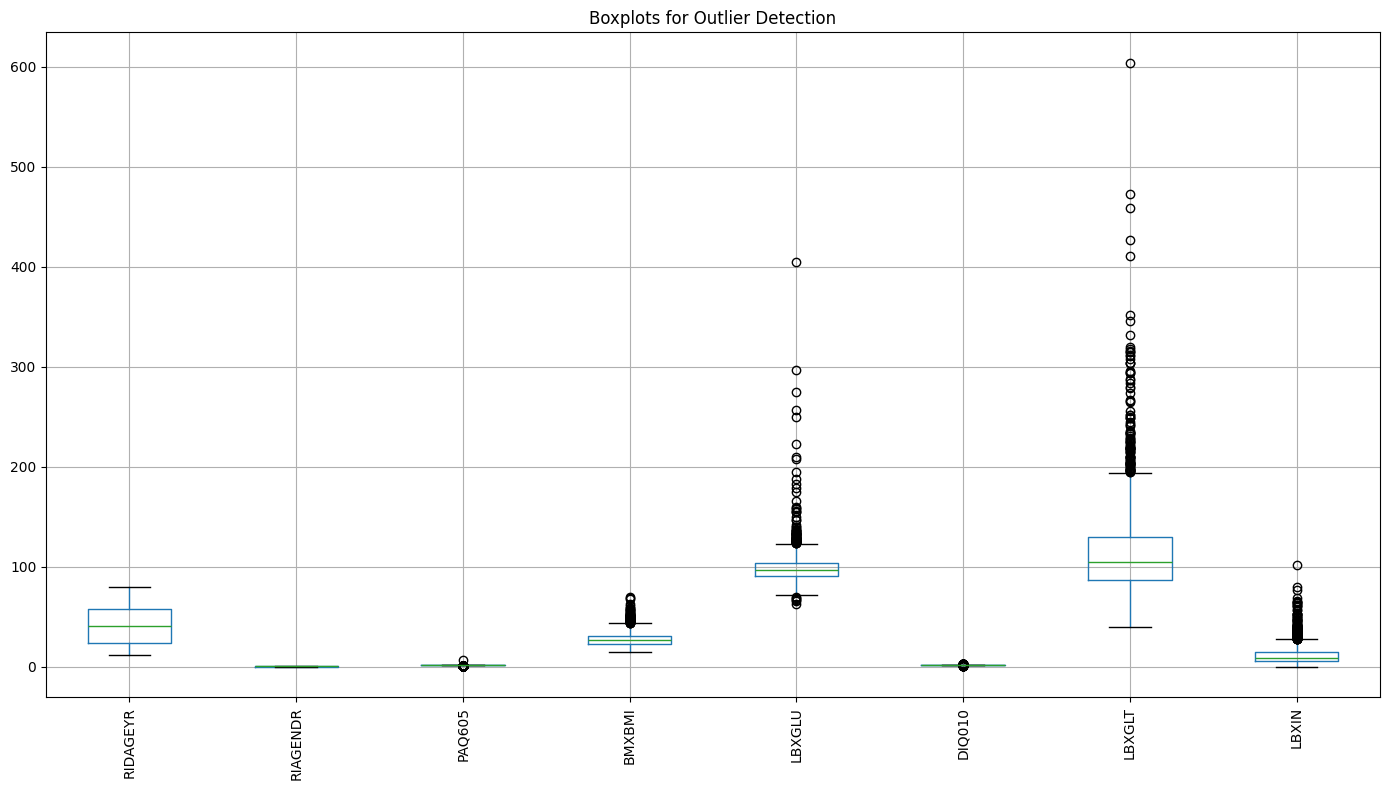

In [54]:
# Checking for Outliers and removing them in the next cell
plt.figure(figsize=(14,8))
X_feat.boxplot(rot=90)
plt.title("Boxplots for Outlier Detection")
plt.tight_layout()
plt.show()

In [55]:
X_feat = imputer.fit_transform(X_feat)
X_feat = pd.DataFrame(X_feat, columns=X.columns)

if np.isnan(X_feat).any().any():
    print("There are still NaNs in X_feat. Fixing them with mean imputation.")
    X_feat.fillna(X_feat.mean(), inplace=True)

if np.isnan(X_test_feat).any().any():
    X_test_feat.fillna(X_test_feat.mean(), inplace=True)

In [68]:
# Imo I like MinMaxScaler more than StandardScaler and RobustScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_feat)
X_test_scaled = scaler.transform(X_test_feat)

In [57]:
# Final check to see if there are empty values in the dataframe otherwise train_test_split will not run
print("Any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("Any NaNs in X_test_scaled?", np.isnan(X_test_scaled).any())

Any NaNs in X_scaled? False
Any NaNs in X_test_scaled? False


In [58]:
# Worked finally !
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [60]:
# Hyperparameter tuning to get the best parameters and therefore the best model.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [69]:
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [62]:
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [63]:
y_val_pred = best_model.predict(X_val_split)
print("\nClassification Report:")
print(classification_report(y_val_split, y_val_pred))

print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00        63

    accuracy                           1.00       391
   macro avg       1.00      1.00      1.00       391
weighted avg       1.00      1.00      1.00       391

Validation Accuracy: 1.0


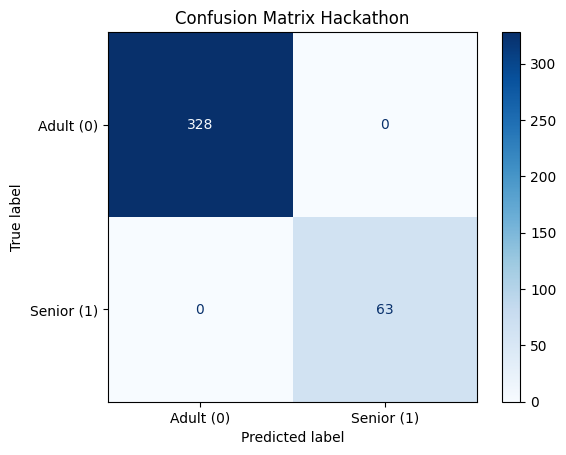

In [64]:
cm = confusion_matrix(y_val_split, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adult (0)', 'Senior (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Hackathon")
plt.show()

In [65]:
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:45] WARNING: C:\actio

Cross-Validation Scores: [1.        1.        1.        1.        0.9974359]
Mean CV Accuracy: 0.9994871794871795


c:\Users\janak\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [66]:
final_preds = best_model.predict(X_test_scaled)

In [67]:
submission = pd.DataFrame({
    'age_group': final_preds
})
submission.to_csv("submission.csv", index=False)